# COCO Reader with augmentations

Reader operator that reads a COCO dataset (or subset of COCO), which consists of an annotation file and the images directory.

In [1]:
from __future__ import print_function
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types
import numpy as np
from time import time
import os.path

test_data_root = os.environ['DALI_EXTRA_PATH']
file_root = os.path.join(test_data_root, 'db', 'coco', 'images')

annotations_file = os.path.join(test_data_root, 'db', 'coco', 'instances.json')
num_gpus = 1
batch_size = 16

Create reader, decoder and flip operator for images and bounding boxes

In [2]:
class COCOPipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super(COCOPipeline, self).__init__(
            batch_size, num_threads, device_id, seed=15)
        self.input = ops.COCOReader(
            file_root=file_root,
            annotations_file=annotations_file,
            shard_id=device_id,
            num_shards=num_gpus,
            ratio=True,
            ltrb=True)
        self.decode = ops.ImageDecoder(device="mixed", output_type=types.RGB)
        self.flip = ops.Flip(device="gpu")
        self.bbflip = ops.BbFlip(device="cpu", ltrb=True)
        self.paste_pos = ops.Uniform(range=(0, 1))
        self.paste_ratio = ops.Uniform(range=(1, 2))
        self.coin = ops.CoinFlip(probability=0.5)
        self.coin2 = ops.CoinFlip(probability=0.5)
        self.paste = ops.Paste(device="gpu", fill_value=(32, 64, 128))
        self.bbpaste = ops.BBoxPaste(device="cpu", ltrb=True)
        self.prospective_crop = ops.RandomBBoxCrop(
            device="cpu",
            aspect_ratio=[0.5, 2.0],
            thresholds=[0.1, 0.3, 0.5],
            scaling=[0.8, 1.0],
            ltrb=True)
        self.slice = ops.Slice(device="gpu")

    def define_graph(self):
        rng = self.coin()
        rng2 = self.coin2()

        inputs, bboxes, labels = self.input()
        images = self.decode(inputs)

        # Paste and BBoxPaste need to use same scales and positions
        ratio = self.paste_ratio()
        px = self.paste_pos()
        py = self.paste_pos()
        images = self.paste(images, paste_x=px, paste_y=py, ratio=ratio)
        bboxes = self.bbpaste(bboxes, paste_x=px, paste_y=py, ratio=ratio)

        crop_begin, crop_size, bboxes, labels = self.prospective_crop(bboxes, labels)
        images = self.slice(images, crop_begin, crop_size)

        images = self.flip(images, horizontal=rng, vertical=rng2)
        bboxes = self.bbflip(bboxes, horizontal=rng, vertical=rng2)

        return (images, bboxes, labels)                                           

In [3]:
start = time()
pipes = [COCOPipeline(batch_size=batch_size, num_threads=2, device_id=device_id)  for device_id in range(num_gpus)]
for pipe in pipes:
    pipe.build()
total_time = time() - start
print("Computation graph built and dataset loaded in %f seconds." % total_time)

Computation graph built and dataset loaded in 0.160288 seconds.


In [4]:
pipe_out = [pipe.run() for pipe in pipes]

images_cpu = pipe_out[0][0].as_cpu()
bboxes_cpu = pipe_out[0][1]
labels_cpu = pipe_out[0][2]

Bounding boxes returned by the operator are lists of floats in format **\[left, top, right, bottom]** in relative cooradinates (ratio=**True**).

In [5]:
img_index = 4

bboxes = bboxes_cpu.at(4)
bboxes

array([[0.7410145 , 0.24397361, 0.7914276 , 0.646856  ]], dtype=float32)

Let's see the ground truth bounding boxes drawn on the image.

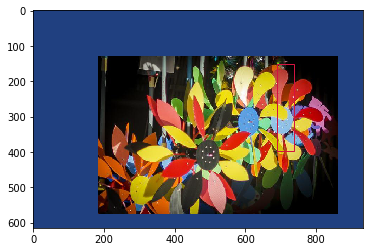

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

img = images_cpu.at(img_index)

H = img.shape[0]
W = img.shape[1]
fig,ax = plt.subplots(1)

ax.imshow(img)
bboxes = bboxes_cpu.at(img_index)
labels = labels_cpu.at(img_index)
categories_set = set()
for label in labels:
    categories_set.add(label[0])

category_id_to_color = dict(
    [(cat_id, [random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)]) for cat_id in categories_set])

for bbox, label in zip(bboxes, labels):
    rect = patches.Rectangle(
        (bbox[0] * W, bbox[1] * H), # Absolute corner coordinates
        (bbox[2] - bbox[0]) * W,    # Absolute bounding box width
        (bbox[3] - bbox[1]) * H,    # Absolute bounding box height
        linewidth=1,
        edgecolor=category_id_to_color[label[0]],
        facecolor='none')
    ax.add_patch(rect)

plt.show()